# imports

In [1]:
import pandas as pd
import numpy as np; np.random.seed(0)
import matplotlib.pyplot as plt; plt.rcParams['font.family'] = 'Malgun Gothic'
import seaborn as sns; sns.set(font='Malgun Gothic')

from scipy.stats import skew, kurtosis

import warnings; warnings.filterwarnings(action='ignore')
from IPython.core.display import display, HTML
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

In [2]:
from sklearn import datasets

# sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

# preprocessing
from sklearn.impute import SimpleImputer, MissingIndicator, KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.preprocessing import Binarizer
from sklearn.decomposition import PCA

# estimators
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from xgboost import XGBClassifier, XGBRegressor, XGBRFClassifier, XGBRFRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

# neural
import tensorflow as tf; tf.random.set_seed(0)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ensemble
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, VotingClassifier, VotingRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor

# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error

# curves
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV

# tools
import pycaret as pyc
import optuna

# read

In [3]:
# from pykrx import stock
# df = stock.get_index_ohlcv_by_date("20150101", "20201231", "1028")
# df = df.reset_index()
# print(df.head(2))
# df.to_csv("kospi.csv", index=False)

In [14]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [5]:
df = pd.read_csv('./input/kospi.csv')

In [6]:
df.head()

,날짜,시가,고가,저가,종가,거래량,거래대금
0,2015-01-02,243.96,245.32,243.25,244.79,54153879,2146860296567
1,2015-01-05,243.83,244.56,241.76,244.26,62845108,2622821317695
2,2015-01-06,241.36,242.06,239.32,239.93,66249937,2992594273218
3,2015-01-07,239.41,240.91,239.09,240.53,54599968,2610334705312
4,2015-01-08,242.28,244.13,241.68,243.94,64021136,3155894203006


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1475 entries, 0 to 1474
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   날짜      1475 non-null   object 
 1   시가      1475 non-null   float64
 2   고가      1475 non-null   float64
 3   저가      1475 non-null   float64
 4   종가      1475 non-null   float64
 5   거래량     1475 non-null   int64  
 6   거래대금    1475 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 80.8+ KB


In [8]:
df['날짜'].min(), df['날짜'].max()

('2015-01-02', '2020-12-30')

In [10]:
close_df = df[['날짜', '종가']].sort_values('날짜').set_index('날짜')
close_df.head()

,종가
날짜,
2015-01-02,244.79
2015-01-05,244.26
2015-01-06,239.93
2015-01-07,240.53
2015-01-08,243.94


<AxesSubplot:xlabel='날짜'>

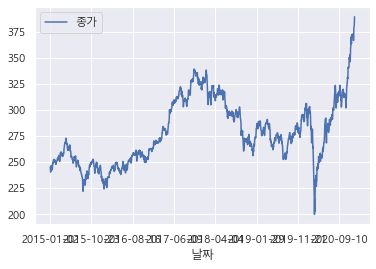

In [13]:
close_df.plot()

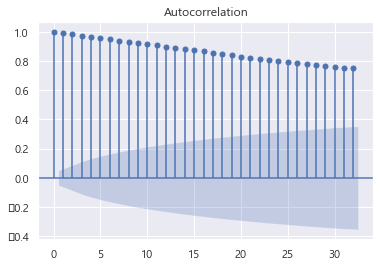

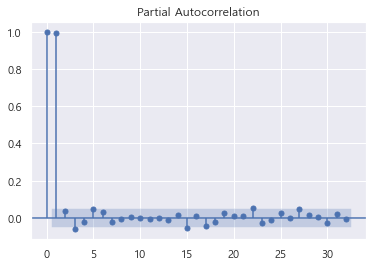

In [18]:
plot_acf(close_df)  # 
plot_pacf(close_df) # MA(p) == 1
plt.show()

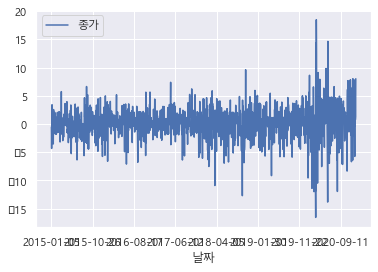

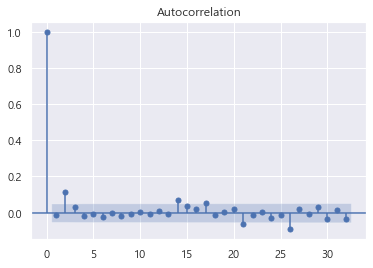

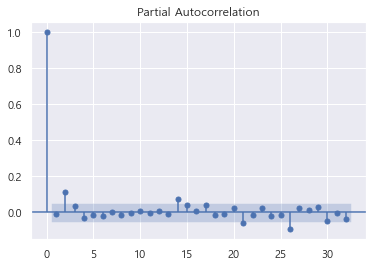

In [22]:
# 차분 후 정상성 확인

after_diff = close_df.diff(periods=1).iloc[1:] # d == 1
after_diff.plot()
plot_acf(after_diff)
plot_pacf(after_diff)
plt.show()

In [23]:
air = pd.read_csv('./input/daily_seoul_air_cond_2020.04.csv')

In [24]:
air.head()

,측정일시,권역코드,권역명,측정소코드,측정소명,미세먼지 1시간(㎍/㎥),미세먼지 24시간(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소농도(ppm),일산화탄소농도(ppm),아황산가스농도(ppm)
0,202004302300,100,도심권,111123,종로구,40,43,21,0.036,0.008,0.3,0.003
1,202004302300,100,도심권,111121,중구,31,41,22,0.037,0.010,0.3,0.003
2,202004302300,100,도심권,111131,용산구,41,40,21,0.035,0.011,0.3,0.002
3,202004302300,101,서북권,111181,은평구,32,37,20,0.053,0.005,0.3,0.003
4,202004302300,101,서북권,111201,마포구,34,34,21,0.043,0.009,0.3,0.002


In [26]:
air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   측정일시            18000 non-null  int64  
 1   권역코드            18000 non-null  int64  
 2   권역명             18000 non-null  object 
 3   측정소코드           18000 non-null  int64  
 4   측정소명            18000 non-null  object 
 5   미세먼지 1시간(㎍/㎥)   18000 non-null  int64  
 6   미세먼지 24시간(㎍/㎥)  18000 non-null  int64  
 7   초미세먼지(㎍/㎥)      18000 non-null  int64  
 8   오존(ppm)         18000 non-null  float64
 9   이산화질소농도(ppm)    18000 non-null  float64
 10  일산화탄소농도(ppm)    18000 non-null  float64
 11  아황산가스농도(ppm)    18000 non-null  float64
dtypes: float64(4), int64(6), object(2)
memory usage: 1.6+ MB


In [30]:
air = air[air['측정소명'] == '중구']

In [33]:
air = air.sort_values('측정일시').set_index('측정일시')

In [36]:
air.drop(['권역코드', '권역명', '측정소코드', '측정소명'], axis=1, inplace=True)

In [41]:
air = air[['초미세먼지(㎍/㎥)']]

In [60]:
air = air.iloc[:-5]

<AxesSubplot:xlabel='측정일시'>

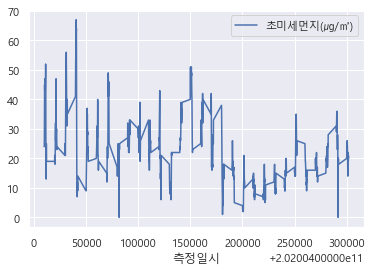

In [61]:
air.plot()

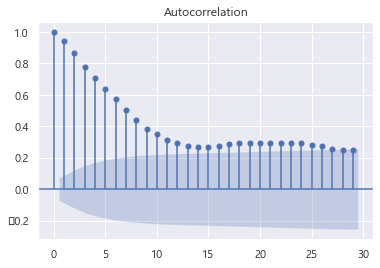

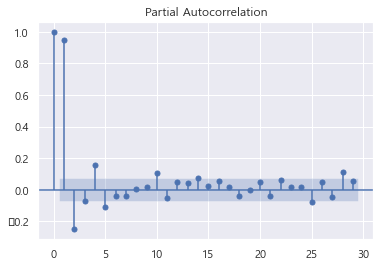

In [62]:
plot_acf(air)  # ?
plot_pacf(air) # p = 3
plt.show()

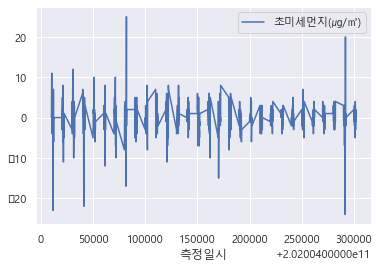

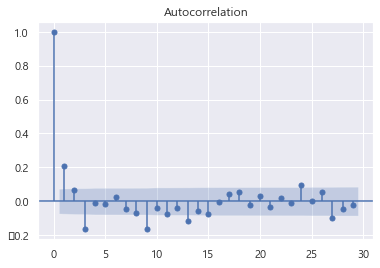

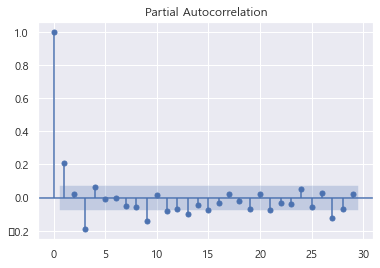

In [63]:
# 차분 후 정상성 확인

after_diff = air.diff(periods=1).iloc[1:] # d == 1
after_diff.plot()
plot_acf(after_diff)
plot_pacf(after_diff)
plt.show()

In [69]:
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore')

model = ARIMA(air, order=(3,1,3))
arima_res = model.fit(trend='c', full_output=True, disp=1)
print(arima_res.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.초미세먼지(㎍/㎥)   No. Observations:                  714
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1930.751
Method:                       css-mle   S.D. of innovations              3.606
Date:                Thu, 21 Oct 2021   AIC                           3877.502
Time:                        14:59:19   BIC                           3914.069
Sample:                             1   HQIC                          3891.624
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0215      0.008     -2.758      0.006      -0.037      -0.006
ar.L1.D.초미세먼지(㎍/㎥)     0.4682      0.130      3.595      0.000       0.213       0.723
ar.L2.D.초미세먼지(㎍/㎥)  

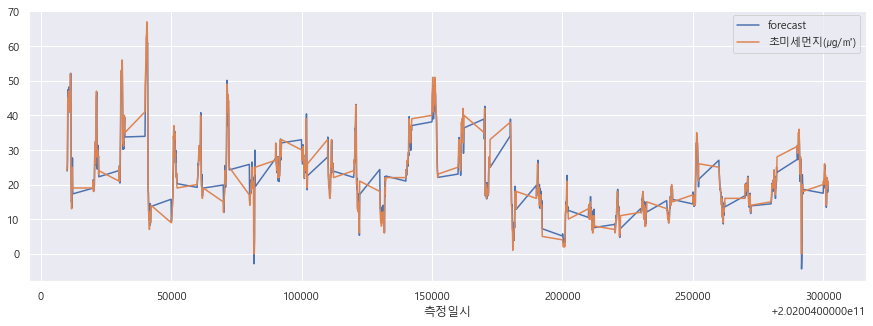

In [70]:
pig, ax = plt.subplots(figsize=(15,5))
arima_res.plot_predict(ax=ax)
plt.show()

In [74]:
fore = arima_res.forecast(steps=5)
#  예측값, stderr,   upper bound~lower bound 
# print(fore)
# print(np.array(fore[0])/1000)

In [76]:
print(fore)

(array([19.98748372, 18.84946875, 18.52771807, 18.04478027, 17.63740252]), array([3.60554242, 5.55229461, 7.08084287, 7.91760175, 8.55468333]), array([[12.92075043, 27.054217  ],
       [ 7.96717129, 29.73176621],
       [ 4.64952106, 32.40591508],
       [ 2.52656599, 33.56299455],
       [ 0.87053129, 34.40427374]]))


In [82]:
print([20, 26, 18, 21, 22])
print(fore[0])
print(fore[1])
print(fore[2])

[20, 26, 18, 21, 22]
[19.98748372 18.84946875 18.52771807 18.04478027 17.63740252]
[3.60554242 5.55229461 7.08084287 7.91760175 8.55468333]
[[12.92075043 27.054217  ]
 [ 7.96717129 29.73176621]
 [ 4.64952106 32.40591508]
 [ 2.52656599 33.56299455]
 [ 0.87053129 34.40427374]]
